<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_01_Custom_Learning_Rate_Scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Define model
def build_model():
    return keras.Sequential([
        keras.Input(shape=(784,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

model = build_model()

In [4]:
#  Define OneCycleScheduler callback
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, max_lr, total_steps):
        super().__init__()
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.step = 0
        self.lrs = []

    def on_train_batch_begin(self, batch, logs=None):
        pct = self.step / self.total_steps
        if pct < 0.3:
            lr = self.max_lr * (pct / 0.3)
        else:
            lr = self.max_lr * (1 - (pct - 0.3) / 0.7)

        # Set learning rate ONLY if it's a variable
        if isinstance(self.model.optimizer.learning_rate, tf.Variable):
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        self.lrs.append(lr)
        self.step += 1

In [5]:
# ✅ Explicitly create optimizer object
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [6]:
# Compile model
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
# Setup scheduler
batch_size = 32
epochs = 5
total_steps = (x_train.shape[0] // batch_size) * epochs
scheduler_cb = OneCycleScheduler(max_lr=0.005, total_steps=total_steps)

In [8]:
# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[scheduler_cb]
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7836 - loss: 0.6028 - val_accuracy: 0.8396 - val_loss: 0.4375
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8677 - loss: 0.3613 - val_accuracy: 0.8551 - val_loss: 0.3983
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8782 - loss: 0.3271 - val_accuracy: 0.8667 - val_loss: 0.3709
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8860 - loss: 0.3073 - val_accuracy: 0.8785 - val_loss: 0.3437
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8936 - loss: 0.2824 - val_accuracy: 0.8762 - val_loss: 0.3435


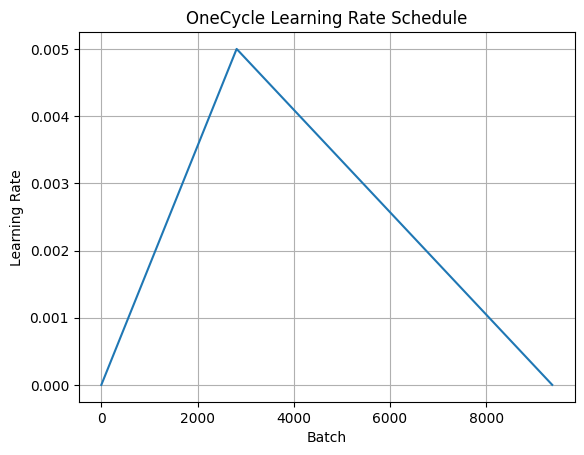

In [9]:
# Plot the learning rate schedule
plt.plot(scheduler_cb.lrs)
plt.title("OneCycle Learning Rate Schedule")
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()
